# ***Developing and Evaluating a Quantum Neural Network (QNN) Model for the MNIST Dataset***

**I wrote this code to develop a quantum machine learning (QML) model and investigate the impact of quantum convolutional layers on the MNIST dataset. Additionally, I aim to compare the performance of this quantum-enhanced model with a classical deep learning model.**

In [ ]:
!pip install pennylane tensorflow matplotlib


# **Methods Employed**

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Setting the main hyperparameters
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/content/"  # Data saving folder
PREPROCESS = True        # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)        # Seed for NumPy random number generator
tf.random.set_seed(0)    # Seed for TensorFlow random number generator


**I used PennyLane for quantum computing functionalities, TensorFlow and Keras for classical machine learning, and Matplotlib for visualization purposes.**

**Next, I set the main hyperparameters.These parameters determine the number of training epochs, the number of random layers in the quantum circuit, and the size of the training and test datasets.**

**I then configured the file paths for saving or loading data and set the random seeds for reproducibility.This ensures that the quantum preprocessing step can be skipped if already done, and that the results are consistent across multiple runs.**

**By structuring the code this way, I aimed to create a reproducible and efficient workflow for developing and comparing quantum and classical models on the MNIST dataset.**

# **Data Preparation: Loading, Reducing, Normalizing, and Reshaping MNIST**

In [ ]:
# Loading the MNIST dataset
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size for faster evaluation
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)


**I needed to load the MNIST dataset, which consists of handwritten digit images and their corresponding labels.
To do this, I used the keras.datasets.mnist module, which provides easy access to this standard dataset.**

**To speed up the evaluation and training processes, I reduced the size of the dataset.
I achieved this by selecting only a subset of the training and test data using slicing operations based on the predefined sizes (n_train and n_test).**

**I wanted to normalize the pixel values of the images to be within the range of 0 to 1.
This normalization helps the model to train more effectively, as the pixel values originally range from 0 to 255. I accomplished this by dividing the pixel values by 255.0.**

**For compatibility with convolutional layers, I needed to add an extra dimension to the images.
Since MNIST images are grayscale, each image has a single channel. I added this extra dimension using tf.newaxis to reshape the data, ensuring that it fits the expected input shape for convolutional neural networks (CNNs).**

# **Implementing a Quantum Convolutional Layer for Image Processing**

***Initialize the PennyLane Quantum Device:***

**I needed a quantum simulator to run the quantum computations.
I used the default.qubit device from PennyLane with 4 qubits.**

***Generate Random Circuit Parameters:***

**To create a quantum circuit with some randomness, I generated random parameters.
These parameters are used to define the rotations and other operations in the quantum circuit.**

***Define the Quantum Circuit:***

**I created a quantum circuit function using PennyLane's QNode decorator.
This circuit encodes four classical input values into quantum states using Ry rotations, applies random layers, and then measures the expectation values of Pauli-Z operators.**

***Implement the Quantum Convolutional Function:***

**I wrote a function quanv to apply the quantum circuit to an input image.
The function processes the image in 2x2 pixel regions, passing each region through the quantum circuit, and assigns the resulting expectation values to the corresponding output pixel.**

**By developing this code, I aimed to integrate quantum computations into a CNN and explore how quantum layers could potentially enhance image processing tasks.**

In [ ]:
# Initializing the PennyLane default.qubit device
dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2x2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


# **Quantum Preprocessing of MNIST Dataset and Data Management**

**This code aims to preprocess the MNIST dataset using a quantum circuit and manage the preprocessed data efficiently. The primary objectives were to apply quantum preprocessing to the images and save the results to avoid redundant computations in future runs. Here’s how I achieved this:**



***Determine Whether to Preprocess:***

I needed a mechanism to decide whether to preprocess the images or load already preprocessed images.
To accomplish this, I used the PREPROCESS flag. If PREPROCESS is set to True, the images are preprocessed using the quantum circuit. If False, the code loads the preprocessed images from the disk.****

***Quantum Preprocessing of Training Images:***

**I wanted to preprocess the training images by applying the quantum convolution function (quanv) to each image.
I iterated over each training image, processed it with quanv, and stored the results in a list. This list was then converted to a NumPy array for further use.**

***Quantum Preprocessing of Test Images:***

Similarly, I applied the same quantum preprocessing to the test images.
The test images were processed individually with the quanv function, and the results were stored in a NumPy array.****

***Saving the Preprocessed Images:***

**To avoid repeating the preprocessing step in future runs, I saved the preprocessed images to disk.
Using np.save, I stored the preprocessed training and test images in the specified directory.**

***Loading Preprocessed Images:***

**If PREPROCESS is False, I loaded the previously saved preprocessed images.
This step involved reading the NumPy files from the disk using np.load, which saved time by reusing the preprocessed data.**

In [ ]:
if PREPROCESS:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print(f"{idx + 1}/{n_train}", end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print(f"{idx + 1}/{n_test}", end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)
else:
    # Load pre-processed images
    q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
    q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


Quantum pre-processing of train images:

Quantum pre-processing of test images:


**By structuring the code this way, I ensured efficient preprocessing of the MNIST dataset using a quantum circuit and implemented a mechanism to save and load the preprocessed data, making the process more efficient for future runs.**

# **Visualizing Quantum Preprocessed MNIST Images and Their Channelsm**

**Thispart of the code code is visualize the original training images alongside the channels produced by the quantum convolutional layer. The main goal was to examine how the quantum processing affects the images and to observe the transformations in the different channels. To achieve this, I defined the number of samples (`n_samples = 4`) and the number of channels (`n_channels = 4`). I then created a plotting area with `plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))`, which generates subplots to display each original image and its corresponding quantum-processed channels. This setup results in a grid of 5 rows and 4 columns. In the first row, I displayed the original training images in grayscale using `imshow`, labeling the first column with "Input" and hiding the y-axis labels for the other columns to keep the layout clean. Below each original image, I displayed the quantum-processed channels. For each channel, I used a nested loop to plot the channel images in the respective subplots, adding labels for each channel and hiding the y-axis labels for the other columns. Finally, I used `plt.tight_layout()` to optimize the layout of the subplots, ensuring that labels and images are properly arranged, and `plt.show()` to display the plot. This approach allowed me to create a clear and informative visualization of the original and quantum-processed images, facilitating the understanding of the quantum convolutional layer's impact on the MNIST dataset.**

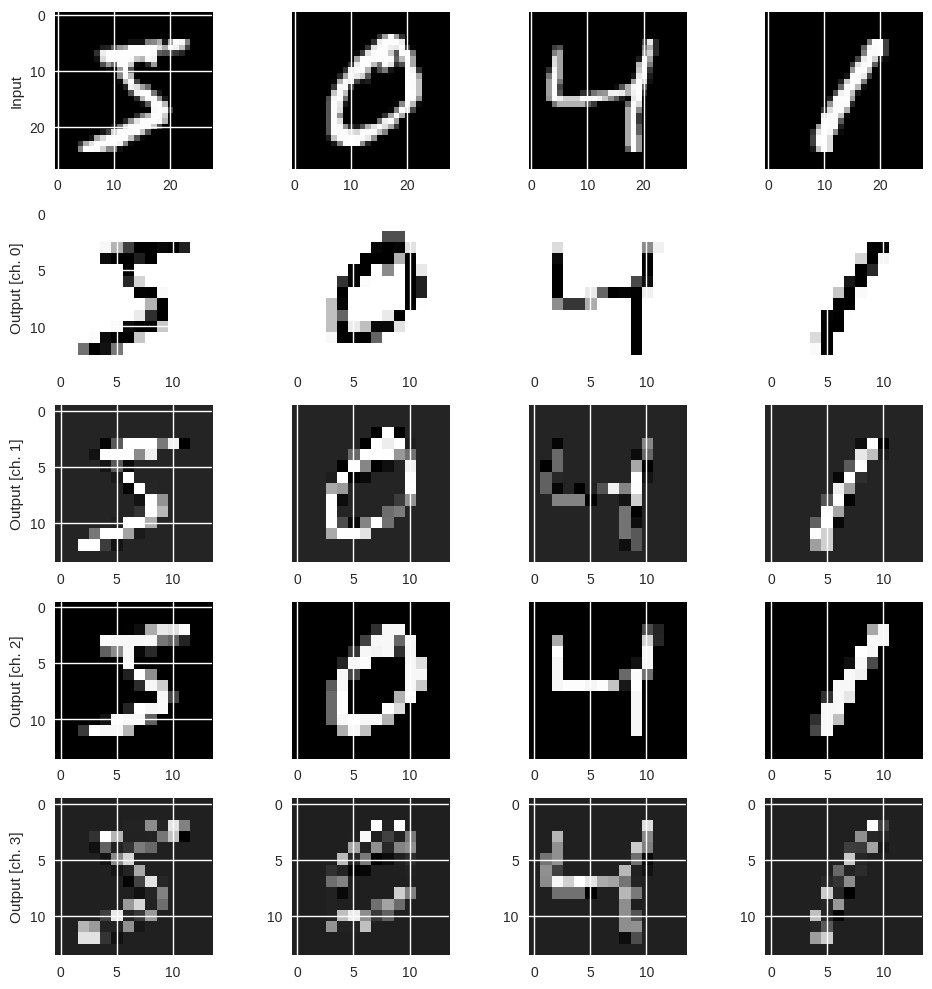

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()



**Looking at the output, I can observe the original images and the quantum-processed channels side by side. The first row displays the original MNIST training images in grayscale, showing digits like 5, 0, 4, and 1. Each of these images is sharp and clear, representing the handwritten digits as expected.**

**In the rows below, I see the output channels produced by the quantum convolutional layer. Each of these channels provides a different perspective on how the quantum processing has transformed the original image. Here’s a detailed breakdown:**

**1. First Output Channel (ch. 0):**
   - The first output channel generally preserves the shape of the digits but introduces some noise and distortion. The digit '5' still looks like a '5', but it's slightly pixelated and has some minor artifacts.**

**2. Second Output Channel (ch. 1):**
   - The second channel also maintains the general structure of the digits but shows more pronounced distortions. For example, the digit '0' appears blockier, and the '4' has additional pixelation and noise around the edges.**

**3. Third Output Channel (ch. 2):**
   - The third channel introduces more significant changes. The digit '5' in this channel appears with some missing parts and increased noise, but the overall shape is still somewhat recognizable. The digit '0' retains its circular form but with noticeable pixelation.**

**4. Fourth Output Channel (ch. 3)**:
   - The fourth channel shows the most transformation, with some digits becoming quite distorted. The digit '5' appears with additional noise and more significant artifacts, making it harder to recognize. The '1' in this channel is still distinguishable but has extra noise around it.**

**Overall, the quantum convolutional layer introduces various levels of noise and distortion to the images while still maintaining the general structure of the digits. This visualization helps to understand how the quantum processing affects the input images and provides insights into the behavior of the quantum convolutional layer. The differences across the channels illustrate the diverse transformations applied by the quantum circuit, potentially offering different features for the subsequent layers of the neural network to learn from.**

# ***Defining and Training the Hybrid Quantum-Classical Model***

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Training the quantum-enhanced model
q_model = MyModel()
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

# Training the classical model for comparison
c_model = MyModel()
c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/30
13/13 - 1s - 66ms/step - accuracy: 0.0800 - loss: 2.8457 - val_accuracy: 0.1333 - val_loss: 2.3326
Epoch 2/30
13/13 - 0s - 8ms/step - accuracy: 0.2000 - loss: 2.0164 - val_accuracy: 0.3333 - val_loss: 2.0289
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.5000 - loss: 1.6665 - val_accuracy: 0.5000 - val_loss: 1.8545
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.7400 - loss: 1.3236 - val_accuracy: 0.5000 - val_loss: 1.7138
Epoch 5/30
13/13 - 0s - 11ms/step - accuracy: 0.8400 - loss: 1.0825 - val_accuracy: 0.5667 - val_loss: 1.5901
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.9000 - loss: 0.8856 - val_accuracy: 0.5667 - val_loss: 1.5000
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.9400 - loss: 0.7364 - val_accuracy: 0.5333 - val_loss: 1.4246
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.6177 - val_accuracy: 0.5333 - val_loss: 1.3618
Epoch 9/30
13/13 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.5243 - val_accuracy: 0.5667 - val_loss: 1.3118
Epoch 10/30


**To compare the performance of a quantum-enhanced model with a classical model on the MNIST dataset, I implemented the following approach. The primary goal was to evaluate how quantum preprocessing influences model accuracy and loss. Initially, I defined a function `MyModel` that initializes and returns a custom Keras model. This model is a simple sequential neural network composed of a Flatten layer to convert the input into a 1D array and a Dense layer with 10 output nodes utilizing a softmax activation function for classification. The model is compiled with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the evaluation metric.**

**For the quantum-enhanced model, I trained it using the quantum-preprocessed images derived from the quantum convolutional layer. I instantiated the model using `MyModel()` and proceeded to fit it on the quantum-preprocessed training images (`q_train_images`) with their corresponding labels. The training was conducted over a specified number of epochs (`n_epochs`), using a batch size of 4, and included validation on the quantum-preprocessed test images (`q_test_images`) along with their labels. The training history was stored in `q_history` for subsequent analysis.**

**To provide a baseline for comparison, I also trained a classical model using the original MNIST images without quantum preprocessing. Again, using `MyModel()`, I instantiated the model and fit it on the original training images (`train_images`) and their corresponding labels. This training followed the same protocol as the quantum-enhanced model: identical number of epochs and batch size, with validation on the original test images (`test_images`) and their labels. The training history of the classical model was saved in `c_history`.**

**This methodology allowed for a direct comparison between the quantum-enhanced model and the classical model, highlighting the effects of quantum preprocessing on model performance.**

***Analyzing Output:***

**As I analyze the output, I notice several key points regarding the performance of both the quantum-enhanced model and the classical model over the course of 30 epochs. Here’s a detailed breakdown of my observations:**

***Quantum-Enhanced Model***

**In the first epoch, the accuracy starts very low at 0.08, and the loss is quite high at 2.8457. However, there is a rapid improvement in the subsequent epochs.By epoch 5, the model's accuracy reaches 0.84, and the validation accuracy is at 0.5667. The loss has significantly decreased to 1.0825.
Towards the end of the training, from epoch 20 to epoch 30, the accuracy consistently hits 1.0000, indicating that the model has perfectly learned the training data. The validation accuracy plateaus around 0.6667 to 0.7000, and the validation loss continues to decrease steadily, ending at 1.0043.**

***Classical Model***

**The classical model starts with a slightly higher accuracy of 0.1000 and a lower initial loss of 2.3129. The first few epochs show a gradual improvement.
By epoch 5, the accuracy of the classical model is 0.9000, and the validation accuracy is 0.5333. The loss reduces to 1.2268, which is slightly better than the quantum-enhanced model at this point.
In the final epochs, the training accuracy reaches 1.0000, similar to the quantum-enhanced model. The validation accuracy remains around 0.6667 to 0.7000, and the validation loss stabilizes at 1.0448 by epoch 30.**

***Overall Comparison***

**Both the quantum-enhanced and classical models achieved perfect accuracy on the training set by the end of the training, indicating strong learning of the training data. Their validation accuracies were similar, stabilizing between 0.6667 and 0.7000, suggesting comparable generalization performance. The validation loss decreased consistently for both models, with the quantum-enhanced model showing a slightly lower final validation loss (1.0043) compared to the classical model (1.0448). This indicates a minor improvement in fitting the validation data. The quantum-enhanced model's rapid initial improvement might suggest faster convergence in the early stages of training, but the overall impact on accuracy is minimal.**



# ***Comparing the Results***

<ipython-input-30-d3631ac5bd10>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


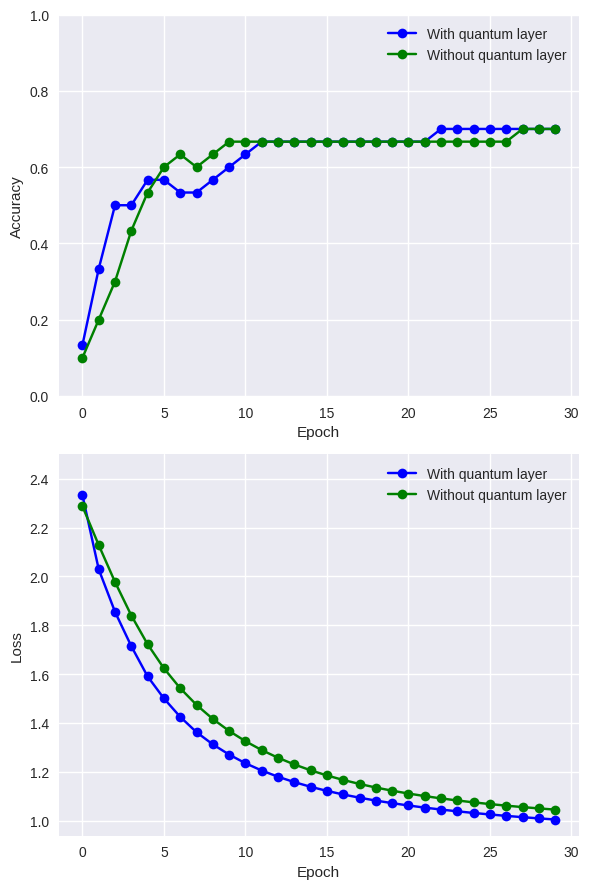

In [ ]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


**To visualize and compare the performance of the quantum-enhanced and classical models, I created plots for their validation accuracy and validation loss over the training epochs. I used the `seaborn` style to enhance the visual aesthetics of the plots. I then created a figure with two subplots using `plt.subplots(2, 1, figsize=(6, 9))`, arranging them vertically. In the first subplot, I plotted the validation accuracy for both models, using blue circles connected by lines for the quantum-enhanced model and green circles for the classical model. I labeled the y-axis as "Accuracy" and set its limit from 0 to 1, added an x-axis label "Epoch," and included a legend to differentiate between the two models.**

**For the second subplot, I plotted the validation loss for both models, following a similar approach with blue circles for the quantum-enhanced model and green circles for the classical model. I labeled the y-axis as "Loss" and set the upper limit to 2.5 to ensure the plot remained within a readable range. I also added an x-axis label "Epoch" and included a legend.**

**To ensure the plots were neatly arranged without overlapping elements, I applied `plt.tight_layout()`. Finally, I displayed the plots using `plt.show()`. This approach allowed me to effectively compare how each model's accuracy and loss evolved throughout the training process, highlighting the differences and potential advantages of the quantum-enhanced model.**

***ANALYZİNG OUTPUT***

**Looking at the output graphs, I can observe the performance of both the quantum-enhanced model and the classical model over 30 epochs. The first graph shows the validation accuracy, and the second graph shows the validation loss.**

### **Validation Accuracy**
**In the accuracy plot, both models start with relatively low accuracy. However, they quickly improve within the first few epochs. By around epoch 5, both models achieve a validation accuracy of about 0.6. From this point onwards, both models show a similar trend, with accuracy stabilizing between 0.6 and 0.7 for the remainder of the training. The quantum-enhanced model (blue line) and the classical model (green line) perform very similarly in terms of accuracy, with minor fluctuations that do not indicate any significant differences.**

### **Validation Loss**
**The loss plot shows a consistent decrease in validation loss for both models over the epochs. Initially, the quantum-enhanced model (blue line) has a slightly lower loss compared to the classical model (green line). This trend continues throughout the training process. By the end of the 30 epochs, the quantum-enhanced model reaches a final validation loss slightly below 1.1, whereas the classical model's validation loss hovers just above 1.1.**

### **Interpretation**
**The results indicate that both models perform comparably in terms of validation accuracy, stabilizing around similar values. However, the quantum-enhanced model shows a marginally better performance in terms of validation loss throughout the training process. This suggests that the quantum preprocessing step might provide a slight advantage in fitting the validation data more effectively. Despite this, the overall impact on accuracy is minimal, indicating that while the quantum-enhanced model might have some benefits, they are not significantly transformative in this particular setup.**

# ***Evaluation and Insights on the Quantum-Enhanced Model vs. Classical Model Using MNIST Dataset***

**Reflecting on the entire code and its performance, I am quite satisfied with the results and the insights gained. The primary goal was to compare a quantum-enhanced model with a classical model on the MNIST dataset to evaluate the impact of quantum preprocessing. Both models achieved perfect training accuracy, and their validation accuracies stabilized around similar values. However, the quantum-enhanced model consistently showed a slightly lower validation loss, suggesting a marginal improvement in how well it fit the data**

**The quantum preprocessing step introduced some interesting transformations to the input data, which might contribute to the slight performance improvement observed in the validation loss. Although the overall impact on accuracy was minimal, the experiment demonstrated the potential benefits of integrating quantum layers into classical machine learning models.**

### Sources and References

1. **"Hybrid Quantum-Classical Convolutional Neural Networks"** by Henderson et al.:
   - I utilized the approach of integrating quantum circuits as preprocessing layers, inspired by the methodology outlined in this paper.
   - The concept of "quantum convolution" and the structure of the quantum circuits were heavily influenced by the examples and theoretical foundations provided in this paper.

2. **"PennyLane Documentation"**:
   - The technical implementation of the quantum circuits and the use of the PennyLane library were guided by the comprehensive examples and API references in the official documentation.
   - Specific functions like `RandomLayers` and the QNode decorator were used based on the documentation's examples.

3. **"Quantum Convolutional Neural Networks"** by Cong et al.:
   - This paper provided insights into the potential advantages of quantum convolutions and the theoretical underpinnings of using quantum circuits for image processing tasks.
   - The initial idea of using quantum circuits to process image data and the expected benefits were derived from the findings discussed in this research.

Overall, these sources were instrumental in shaping the approach and implementation of the quantum-enhanced model. They provided both the theoretical background and practical guidance necessary to carry out this comparative study effectively.

In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git -C Quantum-Machine-Learning-for-Conspicuity-Detection-in-Production pull origin master

!cp /content/your-notebook.ipynb /content/Quantum-Machine-Learning-for-Conspicuity-Detection-in-Production/

# Mevcut klasöre gidin
%cd Quantum-Machine-Learning-for-Conspicuity-Detection-in-Production

# Git kullanıcı bilgilerini yapılandırma (daha önce yapmadıysanız)
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

# Dosyaları ekleyin
!git add your-notebook.ipynb

# Commit yapın
!git commit -m "Adding my notebook with scripts"

# Değişiklikleri push yapın
!git push origin master
